In [1]:
import numpy as np
from   scipy.stats import (multivariate_normal as mvn,
                           norm)
from   scipy.stats._multivariate import _squeeze_output


class multivariate_skewnorm:
    
    def __init__(self, shape, cov=None):
        self.dim   = len(shape)
        self.shape = np.asarray(shape)
        self.mean  = np.zeros(self.dim)
        self.cov   = np.eye(self.dim) if cov is None else np.asarray(cov)

    def pdf(self, x):
        return np.exp(self.logpdf(x))
        
    def logpdf(self, x):
        x    = mvn._process_quantiles(x, self.dim)
        pdf  = mvn(self.mean, self.cov).logpdf(x)
        cdf  = norm(0, 1).logcdf(np.dot(x, self.shape))
        return _squeeze_output(np.log(2) + pdf + cdf)


In [2]:
from itertools import combinations, product
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb
from scipy.spatial import distance

class ReferenceVectors:
    """Class object for reference vectors."""

    def __init__(
        self,
        lattice_resolution: int = None,
        number_of_objectives: int = None,
        creation_type: str = "Uniform",
        vector_type: str = "Spherical",
        ref_point: list = None,
    ):
        """Create a Reference vectors object.

        A simplex lattice is formed

        Parameters
        ----------
        lattice_resolution : int
            Number of divisions along an axis when creating the simplex lattice.
        number_of_objectives : int
            Number of objectives.
        creation_type : str, optional
            'Uniform' creates the reference vectors uniformly using simplex lattice
            design. 'Focused' creates reference vectors symmetrically around a central
            reference vector. 'Reversed' coming soon.By default 'Uniform'.
        vector_type : str, optional
            'Spherical' normalizes the vectors to a hypersphere, i.e. the second norm
            is equal to 1. 'Planar' normalizes vectors to a plane, i.e. the first norm
            is equal to 1. By default 'Spherical'.
        ref_point : list, optional
            User preference information for a priori methods.
        """

        self.number_of_objectives = number_of_objectives
        self.lattice_resolution = lattice_resolution
        self.number_of_vectors = 0
        self.creation_type = creation_type
        self.vector_type = vector_type
        self.values = []
        self.values_planar = []
        self.ref_point = [1] * number_of_objectives if ref_point is None else ref_point
        self._create(creation_type)
        self.initial_values = np.copy(self.values)
        self.initial_values_planar = np.copy(self.values_planar)
        # self.iteractive_adapt_1() Can use this for a priori preferences!

    def _create(self, creation_type: str = "Uniform"):
            number_of_vectors = comb(
                self.lattice_resolution + self.number_of_objectives - 1,
                self.number_of_objectives - 1,
                exact=True,
            )
            self.number_of_vectors = number_of_vectors
            temp1 = range(1, self.number_of_objectives + self.lattice_resolution)
            temp1 = np.array(list(combinations(temp1, self.number_of_objectives - 1)))
            temp2 = np.array(
                [range(self.number_of_objectives - 1)] * self.number_of_vectors
            )
            temp = temp1 - temp2 - 1
            weight = np.zeros(
                (self.number_of_vectors, self.number_of_objectives), dtype=int
            )
            weight[:, 0] = temp[:, 0]
            for i in range(1, self.number_of_objectives - 1):
                weight[:, i] = temp[:, i] - temp[:, i - 1]
            weight[:, -1] = self.lattice_resolution - temp[:, -1]
            self.values = weight / self.lattice_resolution
            self.values_planar = np.copy(self.values)
            self.normalize()
            return
    
    def normalize(self):
        """Normalize the reference vectors to a unit hypersphere."""
        self.number_of_vectors = self.values.shape[0]
        norm_2 = np.linalg.norm(self.values, axis=1)
        norm_1 = np.sum(self.values_planar, axis=1)
        norm_2 = np.repeat(norm_2, self.number_of_objectives).reshape(
            self.number_of_vectors, self.number_of_objectives
        )
        norm_1 = np.repeat(norm_1, self.number_of_objectives).reshape(
            self.number_of_vectors, self.number_of_objectives
        )
        norm_2[norm_2 == 0] = np.finfo(float).eps
        self.values = np.divide(self.values, norm_2)
        self.values_planar = np.divide(self.values_planar, norm_1)


In [3]:
n_of_objectives = 3

#lattice_res_options = [5, 10, 7, 5, 4, 3, 3, 3, 3]
lattice_res_options = [49, 13, 7, 5, 4, 3, 3, 3, 3]
if n_of_objectives < 11:
    lattice_resolution = lattice_res_options[n_of_objectives - 2]
else:
    lattice_resolution = 3
reference_vectors = ReferenceVectors(
                    lattice_resolution, n_of_objectives
)


In [17]:
from scipy.stats import triang
from scipy.stats import truncnorm
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.stats import trapezoid
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

ref_point_orig = [0.1, 0.9, 0.1]
ref_point = ref_point_orig/np.linalg.norm(ref_point_orig)
ref_v = reference_vectors.initial_values_planar
n_ref = np.shape(ref_v)[0]
ref_v_inv_rns = np.zeros((n_ref,n_of_objectives))
for k in range(n_of_objectives):
    ref_v_inv_rns[:,k] = ref_v[:,k]
    mean = ref_point[k]
    #ref_v_inv_rns[:,k] = triang.ppf(q=ref_v[:,k], c=mean, loc=0, scale=1)
    ref_v_inv_rns[:,k] = norm.ppf(q=ref_v[:,k], loc=mean, scale=1)
    #ref_v_inv_rns[:,k] = truncnorm.ppf(q=ref_v[:,k], a=0, b=1, loc=mean, scale=2)
    #ref_v_inv_rns[:,k] = skewnorm.ppf(q=ref_v[:,k], a=mean-0.5, loc=mean, scale=0.2)
    #ref_v_inv_rns[:,k] = trapezoid.ppf(q=ref_v[:,k], c=mean-0.05, d= mean+0.05,loc=0, scale=1)
#nan_array = np.isnan(ref_v_inv_rns,axis=1)
#not_nan_array = ~ nan_array
#ref_v_inv_rns = ref_v_inv_rns[not_nan_array]

norm_2 = np.linalg.norm(ref_v_inv_rns, axis=1)
norm_2 = np.repeat(norm_2, n_of_objectives).reshape(n_ref,n_of_objectives)
ref_v_trx = np.divide(ref_v_inv_rns,norm_2)

ref_v_trx = np.vstack((ref_v_trx,ref_point_orig))
color_column = np.append(np.zeros(n_ref),1)
ref_v_trx = np.hstack((ref_v_trx,color_column.reshape(-1,1)))
df=pd.DataFrame(ref_v_trx)
df.columns = ['0','1','2','3']

#fig = px.scatter_3d(df, x='0', y='1', z='2',color='3')
#fig = px.colors
#fig.update_traces(marker={'size': 3})
#fig.show()
fig = go.Figure(data=[go.Scatter3d(
    x=ref_v_trx[:,0],
    y=ref_v_trx[:,1],
    z=ref_v_trx[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=color_column,                # set color to an array/list of desired values
        colorscale='Bluered',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(    scene = dict(
        xaxis = dict(nticks=4, range=[0,1],),
                     yaxis = dict(nticks=4, range=[0,1],),
                     zaxis = dict(nticks=4, range=[0,1],),),
    margin=dict(l=0, r=0, b=0, t=0))
fig.show()

<ipython-input-17-4c89c5be4b62>:29: RuntimeWarning:

invalid value encountered in true_divide



In [65]:
from scipy.stats import triang

def project_low_dim(ref_v, n_objs):
    n_ref = np.shape(ref_v)[0]
    ref_v_translated = ref_v - np.tile([0,1,0],(n_ref,1))
    ref_v_rot = np.zeros((n_ref,n_objs))
    ref_v_rot[:,0] = ref_v_translated[:,0]*np.cos(np.pi/4.) - ref_v_translated[:,1]*np.sin(np.pi/4.)
    ref_v_rot[:,1] = ref_v_translated[:,0]*np.sin(np.pi/4.) + ref_v_translated[:,1]*np.cos(np.pi/4.)
    ref_v_translated[:,0] = ref_v_rot[:,0]
    ref_v_translated[:,1] = ref_v_rot[:,1]
    norm_fact = np.max(ref_v_rot[:,0])
    #ref_v_rot[:,0] = ref_v_rot[:,0]/norm_fact
    return (ref_v_translated, norm_fact)

def project_high_dim(ref_v_inv_rns, norm_fact, n_objs):
    ref_v_inv_rns[:,0] = ref_v_inv_rns[:,0]*norm_fact
    ref_v_rot2 = np.zeros((n_ref,n_objs))
    ref_v_rot2[:,0] = ref_v_inv_rns[:,0]*np.cos(-np.pi/4.) - ref_v_inv_rns[:,1]*np.sin(-np.pi/4.)
    ref_v_rot2[:,1] = ref_v_inv_rns[:,0]*np.sin(-np.pi/4.) + ref_v_inv_rns[:,1]*np.cos(-np.pi/4.)
    ref_v_translated2 = ref_v_rot2 + np.tile([0,1],(n_ref,1))
    return ref_v_translated2

def inv_sampling(ref_v_low, n_ref, ref_point, n_objs):
    ref_v_inv_rns = np.zeros((n_ref,n_objs))
    for k in range(n_of_objectives-1):
        ref_v_inv_rns[:,k] = ref_v_low[:,k]
        mean = ref_point[0][k]
        ref_v_inv_rns[:,k] = triang.ppf(q=ref_v_inv_rns[:,k], c=mean, loc=0, scale=1)
    return ref_v_inv_rns

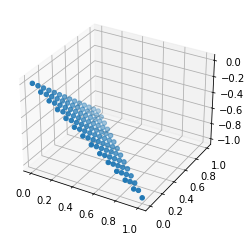

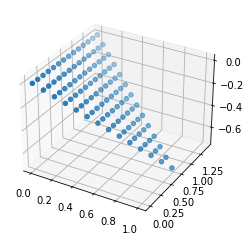

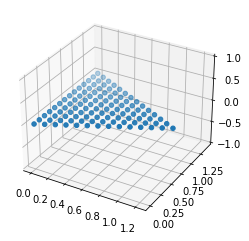

In [102]:
ref_v = reference_vectors.initial_values_planar
n_ref = np.shape(ref_v)[0]
ref_v_translated = ref_v - np.tile([0,0,1],(n_ref,1))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ref_v_translated[:,0],ref_v_translated[:,1],ref_v_translated[:,2])
plt.show()
ref_v_rot = np.zeros((n_ref,n_of_objectives))
ref_v_rot[:,1] = ref_v_translated[:,1]*np.cos(np.pi/4.) - ref_v_translated[:,2]*np.sin(np.pi/4.)
ref_v_rot[:,2] = ref_v_translated[:,1]*np.sin(np.pi/4.) + ref_v_translated[:,2]*np.cos(np.pi/4.)
ref_v_translated[:,1] = ref_v_rot[:,1]
ref_v_translated[:,2] = ref_v_rot[:,2]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ref_v_translated[:,0],ref_v_translated[:,1],ref_v_translated[:,2])
plt.show()

theta2 = np.arctan(np.min(ref_v_translated, axis=0)[2])
ref_v_rot = np.zeros((n_ref,n_of_objectives))
ref_v_rot[:,0] = ref_v_translated[:,0]*np.cos(theta2) + ref_v_translated[:,2]*np.sin(theta2)
ref_v_rot[:,2] = -ref_v_translated[:,0]*np.sin(theta2) + ref_v_translated[:,2]*np.cos(theta2)
ref_v_translated[:,0] = ref_v_rot[:,0]
ref_v_translated[:,2] = ref_v_rot[:,2]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ref_v_translated[:,0],ref_v_translated[:,1],ref_v_translated[:,2])
ax.set_zlim(-1,1)
plt.show()



In [104]:
norm_fact = np.max(ref_v_translated,axis=0)

In [105]:
ref_v_translated_x = ref_v_translated[:,0]/norm_fact[0]
ref_v_translated_y = ref_v_translated[:,1]/norm_fact[1]

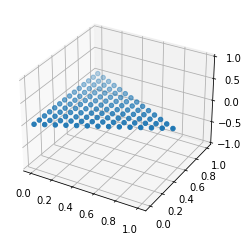

In [106]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ref_v_translated_x,ref_v_translated_y,ref_v_translated[:,2])
ax.set_zlim(-1,1)
plt.show()

In [109]:
ref_point = [0.5,0.5]
ref_v_inv_rns = np.zeros((n_ref,n_of_objectives))
ref_v_inv_rns[:,0] = ref_v_translated_x
mean = ref_point[0]
ref_v_inv_rns[:,0] = triang.ppf(q=ref_v_inv_rns[:,0], c=mean, loc=0, scale=1)
ref_v_inv_rns[:,1] = ref_v_translated_y
mean = ref_point[1]
ref_v_inv_rns[:,1] = triang.ppf(q=ref_v_inv_rns[:,1], c=mean, loc=0, scale=1)

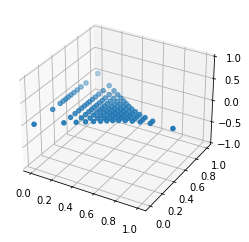

In [110]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ref_v_inv_rns[:,0],ref_v_inv_rns[:,1],ref_v_translated[:,2])
ax.set_zlim(-1,1)
plt.show()

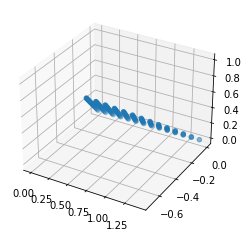

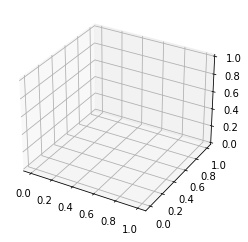

In [67]:
(ref_v_low,norm_fact) = project_low_dim(ref_v_x, n_of_objectives)
ref_v_transformed = inv_sampling(ref_v_low[0:n_ref,:], n_ref, ref_v_low[n_ref:n_ref+1,:], n_of_objectives)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ref_v_low[0:n_ref,0],ref_v_low[0:n_ref,1],ref_v_low[0:n_ref,2])
#plt.ylim(-2,2)
plt.show()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ref_v_transformed[:,0],ref_v_transformed[:,1],ref_v_transformed[:,2])
#plt.ylim(-2,2)
plt.show()

In [68]:
ref_v_low

array([[ 7.07106781e-01, -7.07106781e-01,  1.00000000e+00],
       [ 6.52713952e-01, -6.52713952e-01,  9.23076923e-01],
       [ 5.98321123e-01, -5.98321123e-01,  8.46153846e-01],
       [ 5.43928293e-01, -5.43928293e-01,  7.69230769e-01],
       [ 4.89535464e-01, -4.89535464e-01,  6.92307692e-01],
       [ 4.35142635e-01, -4.35142635e-01,  6.15384615e-01],
       [ 3.80749805e-01, -3.80749805e-01,  5.38461538e-01],
       [ 3.26356976e-01, -3.26356976e-01,  4.61538462e-01],
       [ 2.71964147e-01, -2.71964147e-01,  3.84615385e-01],
       [ 2.17571317e-01, -2.17571317e-01,  3.07692308e-01],
       [ 1.63178488e-01, -1.63178488e-01,  2.30769231e-01],
       [ 1.08785659e-01, -1.08785659e-01,  1.53846154e-01],
       [ 5.43928293e-02, -5.43928293e-02,  7.69230769e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.61499611e-01, -6.52713952e-01,  9.23076923e-01],
       [ 7.07106781e-01, -5.98321123e-01,  8.46153846e-01],
       [ 6.52713952e-01, -5.43928293e-01

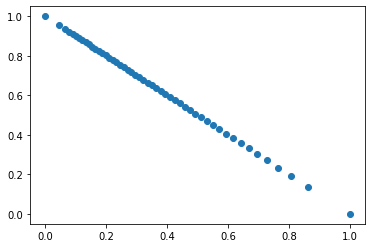

In [26]:
ref_v_high = project_high_dim(ref_v_transformed, norm_fact)
plt.scatter(ref_v_high[:,0],ref_v_high[:,1])
#plt.ylim(-2,2)
plt.show()

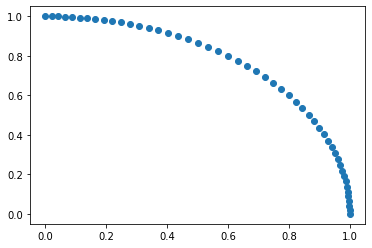

In [4]:
import matplotlib.pyplot as plt

plt.scatter(reference_vectors.initial_values[:,0],reference_vectors.initial_values[:,1])
plt.show()

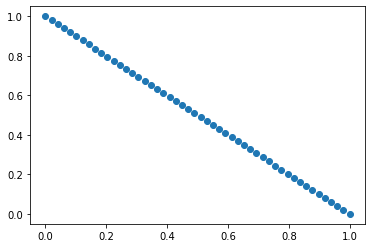

In [5]:
plt.scatter(reference_vectors.initial_values_planar[:,0],reference_vectors.initial_values_planar[:,1])
plt.show()

In [6]:
ref_v = reference_vectors.initial_values_planar
n_ref = np.shape(ref_v)[0]
ref_v_translated = ref_v - np.tile([0,1],(n_ref,1))

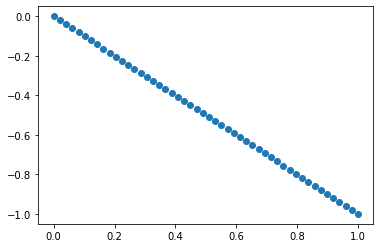

In [7]:
plt.scatter(ref_v_translated[:,0],ref_v_translated[:,1])
plt.show()

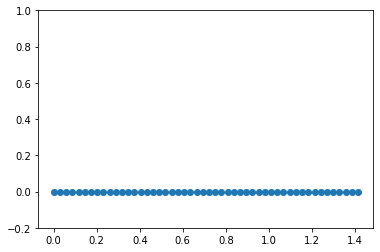

In [8]:
ref_v_rot = np.zeros((n_ref,2))
ref_v_rot[:,0] = ref_v_translated[:,0]*np.cos(np.pi/4.) - ref_v_translated[:,1]*np.sin(np.pi/4.)
ref_v_rot[:,1] = ref_v_translated[:,0]*np.sin(np.pi/4.) + ref_v_translated[:,1]*np.cos(np.pi/4.)
plt.scatter(ref_v_rot[:,0],ref_v_rot[:,1])
#plt.xlim(-0.2, 2)
plt.ylim(-0.2, 1)
plt.show()

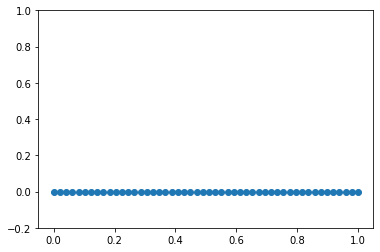

In [9]:
norm_fact = np.max(ref_v_rot[:,0])
ref_v_rot[:,0] = ref_v_rot[:,0]/np.max(ref_v_rot[:,0])
plt.scatter(ref_v_rot[:,0],ref_v_rot[:,1])
#plt.xlim(-0.2, 2)
plt.ylim(-0.2, 1)
plt.show()

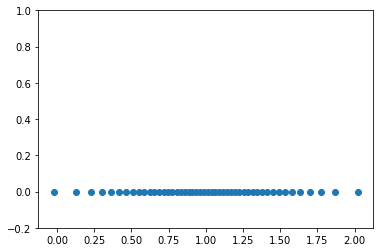

In [113]:
from scipy.stats import norm
ref_v_inv_rns = np.zeros((n_ref,2))
ref_v_inv_rns[:,0] = norm.ppf(q=ref_v_rot[:,0],loc=1, scale=0.5)
plt.scatter(ref_v_inv_rns[:,0],ref_v_inv_rns[:,1])
#plt.xlim(, 1.2)
plt.ylim(-0.2, 1)
plt.show()

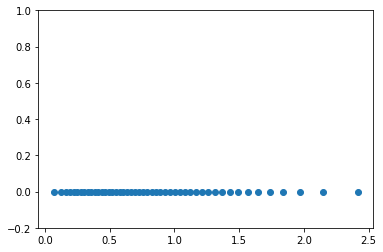

In [21]:
from scipy.stats import skewnorm
ref_v_inv_rns = np.zeros((n_ref,2))
ref_v_inv_rns[:,0] = skewnorm.ppf(q=ref_v_rot[:,0],a=10,loc=0.1, scale=1)
plt.scatter(ref_v_inv_rns[:,0],ref_v_inv_rns[:,1])
#plt.xlim(, 1.2)
plt.ylim(-0.2, 1)
plt.show()

In [ ]:
zz= ref_v_inv_rns[:,0]


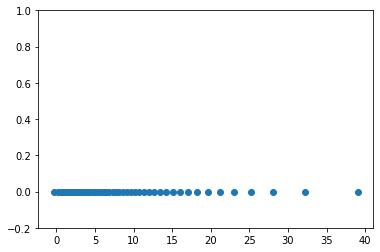

In [22]:
from scipy.stats import exponnorm
ref_v_inv_rns = np.zeros((n_ref,2))
ref_v_inv_rns[:,0] = exponnorm.ppf(q=ref_v_rot[:,0],K=10,loc=0.1, scale=1)
plt.scatter(ref_v_inv_rns[:,0],ref_v_inv_rns[:,1])
#plt.xlim(, 1.2)
plt.ylim(-0.2, 1)
plt.show()

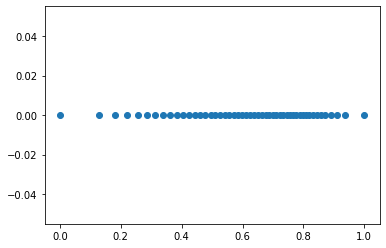

In [42]:
from scipy.stats import triang
ref_v_inv_rns = np.zeros((n_ref,2))
ref_v_inv_rns[:,0] = triang.ppf(q=ref_v_rot[:,0],c=0.8,loc=0, scale=1)
plt.scatter(ref_v_inv_rns[:,0],ref_v_inv_rns[:,1])
#plt.xlim(, 1.2)
#plt.ylim(-0.2, 1)
plt.show()

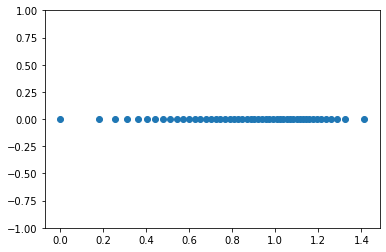

In [43]:
ref_v_inv_rns[:,0] = ref_v_inv_rns[:,0]*norm_fact
plt.scatter(ref_v_inv_rns[:,0],ref_v_inv_rns[:,1])
#plt.xlim(, 1.2)
plt.ylim(-1, 1)
plt.show()

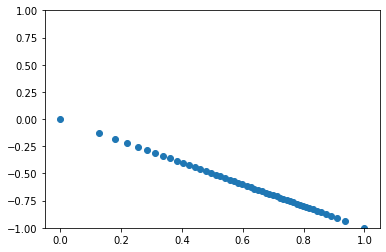

In [44]:
ref_v_rot2 = np.zeros((n_ref,2))
ref_v_rot2[:,0] = ref_v_inv_rns[:,0]*np.cos(-np.pi/4.) - ref_v_inv_rns[:,1]*np.sin(-np.pi/4.)
ref_v_rot2[:,1] = ref_v_inv_rns[:,0]*np.sin(-np.pi/4.) + ref_v_inv_rns[:,1]*np.cos(-np.pi/4.)
plt.scatter(ref_v_rot2[:,0],ref_v_rot2[:,1])
plt.ylim(-1, 1)
plt.show()

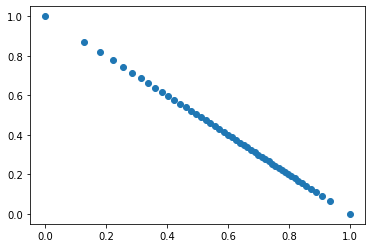

In [46]:
ref_v_translated2 = ref_v_rot2 + np.tile([0,1],(n_ref,1))
plt.scatter(ref_v_translated2[:,0],ref_v_translated2[:,1])
plt.show()

In [141]:
np.median(ref_v_inv_rns[:,0])

0.5000000000000001

In [109]:
x=ref_v_inv_rns[:,0]
nan_array = np.isinf(x)

not_nan_array = ~ nan_array

array2 = x[not_nan_array]
np.mean(array2)
#array2

1.1909938945983878